In [1]:
from rdkit import Chem
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
import itertools
import pandas as pd
from collections import Counter
import mols2grid

Set the default image size

In [2]:
uru.rd_set_image_size(300,300)

Create a demo molecule

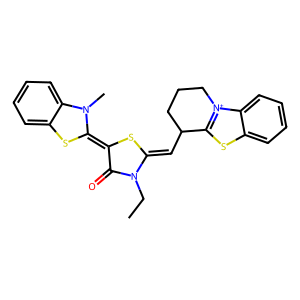

In [3]:
smi = "CCn1c(=O)/c(=C2\Sc3ccccc3N2C)s/c1=C\C1CCC[n+]2c1sc1ccccc12"
mol = Chem.MolFromSmiles(smi)
mol

Instantiate a RingSystemFinder object

In [4]:
ring_system_finder = uru.RingSystemFinder()

In order to demo the algorithm, we'll walk through it step by step.  First, we'll tag the bonds that shouldn't be cleaved when identifying ring systems.  Note that this is just to show how the RingSystemFinder works.  A simple way to find ring systems is shown below.

In [5]:
ring_system_finder.tag_bonds_to_preserve(mol)

Now look at a structure with those bonds highlighted.

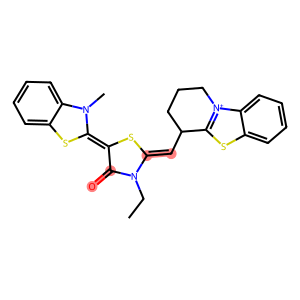

In [6]:
mol

Next, we cleave the tagged bonds.

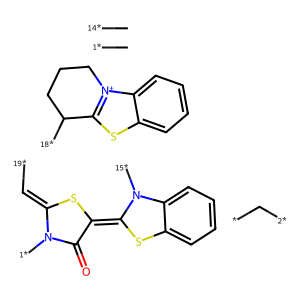

In [7]:
m1 = ring_system_finder.cleave_linker_bonds(mol)
m1

Now we can look at the ring systems.

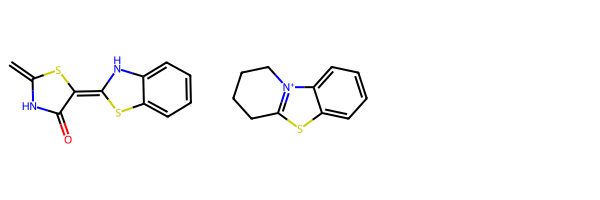

In [8]:
rx = ring_system_finder.cleanup_fragments(m1)
MolsToGridImage(rx)

That was just to show how the algorithm works.  Of course, this can also be done in one step.

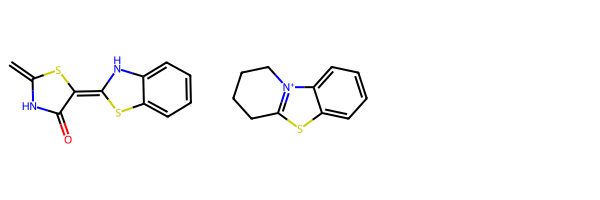

In [9]:
ring_system_list = ring_system_finder.find_ring_systems(mol, as_mols=True)
MolsToGridImage(ring_system_list)

View the ring systems with attached R-groups

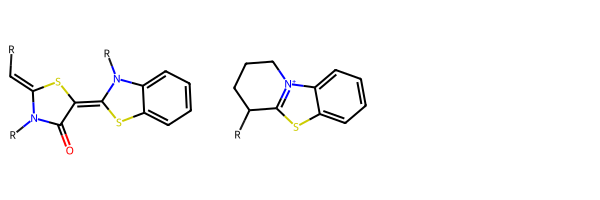

In [10]:
ring_system_list_with_Rgroups = ring_system_finder.find_ring_systems(mol, as_mols=True, keep_dummy=True)
MolsToGridImage(ring_system_list_with_Rgroups)

Let's look at a couple of applications of the RingSystemFinder.
Read a demo dataset

In [11]:
url = "https://raw.githubusercontent.com/PatWalters/useful_rdkit_utils/master/data/test.smi"
df = pd.read_csv(url,sep=" ",names=["SMILES","Name"])

View the dataframe

In [12]:
df

,SMILES,Name
0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,CHEMBL700
1,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+],CHEMBL1200982
2,Cl.N=C(N)N,CHEMBL1200728
3,CC1=CC(=O)c2ccccc2C1=O,CHEMBL590
4,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...,CHEMBL1370561
5,C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[...,CHEMBL1395
6,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@@]2(C)[C@H]1CC...,CHEMBL1536
7,Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[...,CHEMBL3989728
8,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL411
9,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,CHEMBL439


Add an RDKit molecule to the dataframe

In [13]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

In [14]:
df.mol = df.mol.apply(uru.get_largest_fragment)

In [15]:
df.SMILES = df.mol.apply(Chem.MolToSmiles)

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [16]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)

In [17]:
df.ring_sytems.values

array([list(['c1ccccc1', 'c1ccncc1']), list(['O=C1CC(=O)NC(=O)[N-]1']),
       list([]), list(['O=C1C=CC(=O)c2ccccc21']),
       list(['O=c1[nH]c(=O)c2[nH]cnc2[nH]1']),
       list(['O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]2CC1']),
       list(['C=C1CCCCC1=C', 'C=C1CCC[C@@H]2CCC[C@@H]12']),
       list(['c1ccc2ccccc2c1']), list(['c1ccccc1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1cncnc1'])], dtype=object)

See how many times each ring system occurs

In [18]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"])
ring_count_df.sort_values("Count",ascending=False,inplace=True)

View the ring system frequencies

In [19]:
mols2grid.display(ring_count_df,subset=["img","Count"])

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [20]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [21]:
res

0            [(c1ccccc1, 2260082), (c1ccncc1, 231698)]
1                        [(O=C1CC(=O)NC(=O)[N-]1, 11)]
2                                                   []
3                      [(O=C1C=CC(=O)c2ccccc21, 3669)]
4               [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 5703)]
5    [(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@...
6    [(C=C1CCCCC1=C, 567), (C=C1CCC[C@@H]2CCC[C@@H]...
7                            [(c1ccc2ccccc2c1, 49955)]
8           [(c1ccccc1, 2260082), (c1ccccc1, 2260082)]
9             [(c1ccccc1, 2260082), (c1cncnc1, 81465)]
Name: mol, dtype: object

In [22]:
df['ring_freq'] = res.apply(uru.get_min_ring_frequency)

In [23]:
df

,SMILES,Name,mol,ring_sytems,ring_freq
0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,CHEMBL700,<rdkit.Chem.rdchem.Mol object at 0x140a818c0>,"[c1ccccc1, c1ccncc1]","(c1ccncc1, 231698)"
1,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O,CHEMBL1200982,<rdkit.Chem.rdchem.Mol object at 0x140a81930>,[O=C1CC(=O)NC(=O)[N-]1],"(O=C1CC(=O)NC(=O)[N-]1, 11)"
2,N=C(N)N,CHEMBL1200728,<rdkit.Chem.rdchem.Mol object at 0x140a81a10>,[],"[, -1]"
3,CC1=CC(=O)c2ccccc2C1=O,CHEMBL590,<rdkit.Chem.rdchem.Mol object at 0x140a819a0>,[O=C1C=CC(=O)c2ccccc21],"(O=C1C=CC(=O)c2ccccc21, 3669)"
4,Cn1c(=O)c2[nH]cnc2n(C)c1=O,CHEMBL1370561,<rdkit.Chem.rdchem.Mol object at 0x140a81a80>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],"(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 5703)"
5,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...,CHEMBL1395,<rdkit.Chem.rdchem.Mol object at 0x140a81af0>,[O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H...,(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H...
6,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,CHEMBL1536,<rdkit.Chem.rdchem.Mol object at 0x140a81b60>,"[C=C1CCCCC1=C, C=C1CCC[C@@H]2CCC[C@@H]12]","(C=C1CCCCC1=C, 567)"
7,Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[O-],CHEMBL3989728,<rdkit.Chem.rdchem.Mol object at 0x140a81bd0>,[c1ccc2ccccc2c1],"(c1ccc2ccccc2c1, 49955)"
8,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL411,<rdkit.Chem.rdchem.Mol object at 0x140a81c40>,"[c1ccccc1, c1ccccc1]","(c1ccccc1, 2260082)"
9,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,CHEMBL439,<rdkit.Chem.rdchem.Mol object at 0x140a81cb0>,"[c1ccccc1, c1cncnc1]","(c1cncnc1, 81465)"


In [24]:
mols2grid.display(df.sort_values("ring_freq"),mol_col="mol",subset=["img","ring_freq"])

TypeError: '<' not supported between instances of 'list' and 'tuple'

In [25]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)

In [26]:
df.ring_sytems.values

array([list(['c1ccccc1', 'c1ccncc1']), list(['O=C1CC(=O)NC(=O)[N-]1']),
       list([]), list(['O=C1C=CC(=O)c2ccccc21']),
       list(['O=c1[nH]c(=O)c2[nH]cnc2[nH]1']),
       list(['O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]2CC1']),
       list(['C=C1CCCCC1=C', 'C=C1CCC[C@@H]2CCC[C@@H]12']),
       list(['c1ccc2ccccc2c1']), list(['c1ccccc1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1cncnc1'])], dtype=object)

See how many times each ring system occurs

In [27]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"])
ring_count_df.sort_values("Count",ascending=False,inplace=True)

View the ring system frequencies

In [28]:
mols2grid.display(ring_count_df,subset=["img","Count"])

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [29]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [30]:
res

0            [(c1ccccc1, 2260082), (c1ccncc1, 231698)]
1                        [(O=C1CC(=O)NC(=O)[N-]1, 11)]
2                                                   []
3                      [(O=C1C=CC(=O)c2ccccc21, 3669)]
4               [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 5703)]
5    [(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@...
6    [(C=C1CCCCC1=C, 567), (C=C1CCC[C@@H]2CCC[C@@H]...
7                            [(c1ccc2ccccc2c1, 49955)]
8           [(c1ccccc1, 2260082), (c1ccccc1, 2260082)]
9             [(c1ccccc1, 2260082), (c1cncnc1, 81465)]
Name: mol, dtype: object

In [31]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()

In [32]:
df

,SMILES,Name,mol,ring_sytems,ring_freq,min_ring,min_freq
0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,CHEMBL700,<rdkit.Chem.rdchem.Mol object at 0x140a818c0>,"[c1ccccc1, c1ccncc1]","(c1ccncc1, 231698)",c1ccncc1,231698
1,CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O,CHEMBL1200982,<rdkit.Chem.rdchem.Mol object at 0x140a81930>,[O=C1CC(=O)NC(=O)[N-]1],"(O=C1CC(=O)NC(=O)[N-]1, 11)",O=C1CC(=O)NC(=O)[N-]1,11
2,N=C(N)N,CHEMBL1200728,<rdkit.Chem.rdchem.Mol object at 0x140a81a10>,[],"[, -1]",,-1
3,CC1=CC(=O)c2ccccc2C1=O,CHEMBL590,<rdkit.Chem.rdchem.Mol object at 0x140a819a0>,[O=C1C=CC(=O)c2ccccc21],"(O=C1C=CC(=O)c2ccccc21, 3669)",O=C1C=CC(=O)c2ccccc21,3669
4,Cn1c(=O)c2[nH]cnc2n(C)c1=O,CHEMBL1370561,<rdkit.Chem.rdchem.Mol object at 0x140a81a80>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],"(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 5703)",O=c1[nH]c(=O)c2[nH]cnc2[nH]1,5703
5,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...,CHEMBL1395,<rdkit.Chem.rdchem.Mol object at 0x140a81af0>,[O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H...,(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H...,O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]...,494
6,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,CHEMBL1536,<rdkit.Chem.rdchem.Mol object at 0x140a81b60>,"[C=C1CCCCC1=C, C=C1CCC[C@@H]2CCC[C@@H]12]","(C=C1CCCCC1=C, 567)",C=C1CCCCC1=C,567
7,Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[O-],CHEMBL3989728,<rdkit.Chem.rdchem.Mol object at 0x140a81bd0>,[c1ccc2ccccc2c1],"(c1ccc2ccccc2c1, 49955)",c1ccc2ccccc2c1,49955
8,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL411,<rdkit.Chem.rdchem.Mol object at 0x140a81c40>,"[c1ccccc1, c1ccccc1]","(c1ccccc1, 2260082)",c1ccccc1,2260082
9,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,CHEMBL439,<rdkit.Chem.rdchem.Mol object at 0x140a81cb0>,"[c1ccccc1, c1cncnc1]","(c1cncnc1, 81465)",c1cncnc1,81465


In [33]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])